## Import librairies

In [178]:
%matplotlib inline

from time import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification, load_digits
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from yellowbrick.cluster import InterclusterDistance, SilhouetteVisualizer, KElbowVisualizer


pd.set_option("display.max_columns", None)

## Load the dataset

We will start by loading the digits dataset. This dataset contains handwritten digits from 0 to 9. In the context of clustering, one would like to group images such that the handwritten digits on the image are the same.

In [181]:
digits = load_digits()  # Dimensionality: 64 features

X, labels = digits.data, digits.target
images = digits.images

# column name for 64
column_names = [f"X{i}" for i in range(64)]

data = pd.DataFrame(X, columns=column_names).assign(label=labels)

(n_samples, n_features), n_digits = X.shape, np.unique(labels).size

print(f"# digits: {n_digits}; # samples: {n_samples}; # features {n_features}")

# digits: 10; # samples: 1797; # features 64


In [182]:
data.head() 

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4


## EDA

C:\Users\User\AppData\Local\Temp\ipykernel_4580\3374211802.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='label', data=data, palette='tab10')


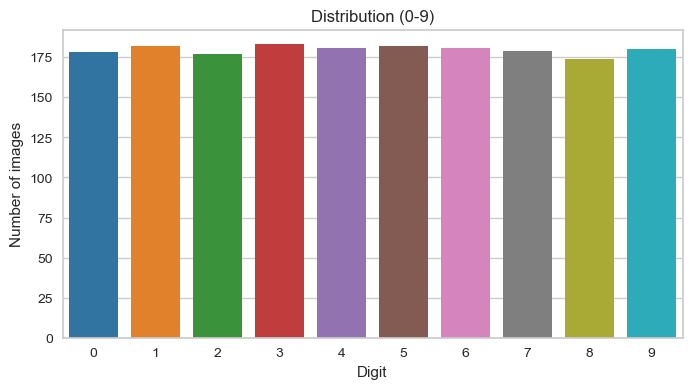

In [185]:
plt.figure(figsize=(8, 4))
sns.countplot(x='label', data=data, palette='tab10')

plt.title("Distribution (0-9)")
plt.xlabel("Digit")
plt.ylabel("Number of images")
plt.show()

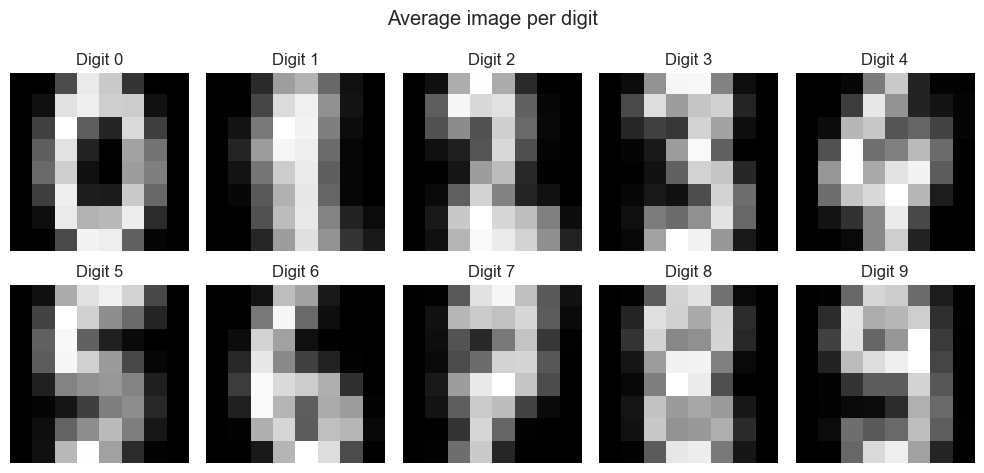

In [186]:
# mean by digit
mean_images = np.zeros((10, 64))  # 64 pixels
for i in range(10):
    mean_images[i] = data.loc[data.label == i, column_names].mean(axis=0)



fig, axs = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axs.flat):
    ax.imshow(mean_images[i].reshape(8, 8), cmap='gray')
    ax.set_title(f"Digit {i}")
    ax.axis('off') 
plt.suptitle("Average image per digit")
plt.tight_layout()
plt.show() 


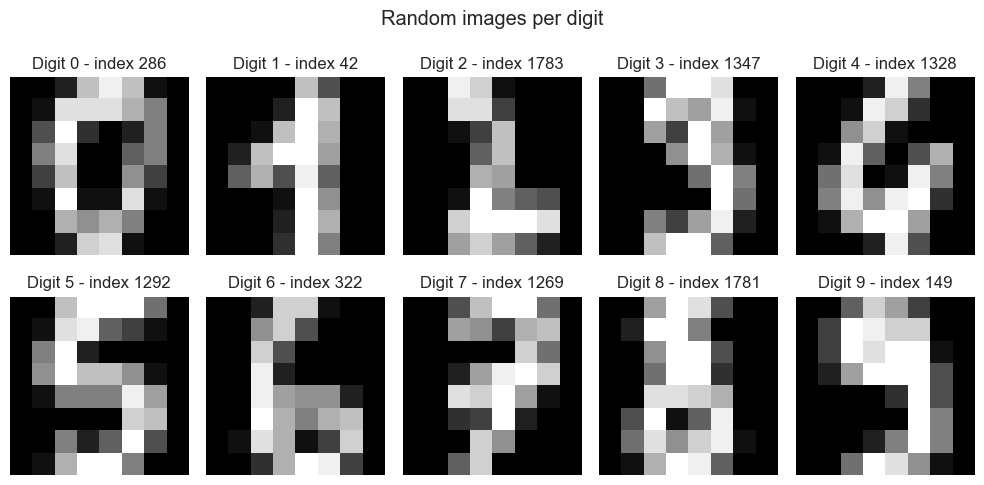

In [187]:
fig, axs = plt.subplots(2, 5, figsize=(10, 5))
plt.subplots_adjust(left=0.01, right=0.99, bottom=0.01, top=0.91, hspace=0.5)

for i, label in enumerate(np.unique(labels)):
    ax = axs[i // 5, i % 5]
    # Random choice by digit
    idx = np.random.choice(np.where(labels == label)[0])
    ax.imshow(images[idx], cmap='gray')
    ax.set_title(f"Digit {label} - index {idx}")
    ax.axis('off')

plt.suptitle("Random images per digit")
plt.tight_layout()
plt.show();

## Define our evaluation benchmark

We will first our evaluation benchmark. During this benchmark, we intend to compare different initialization methods for KMeans. Our benchmark will:

create a pipeline which will scale the data using a StandardScaler;

train and time the pipeline fitting;

measure the performance of the clustering obtained via different metrics.


In [190]:
def bench_k_means(kmeans, name, data, labels):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    labels : ndarray of shape (n_samples,)
        The labels used to compute the clustering metrics which requires some
        supervision.
    """
    t0 = time()
    estimator = make_pipeline(MinMaxScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # Define the metrics which require only the true labels and estimator
    # labels
    clustering_metrics = [
        metrics.homogeneity_score,
        metrics.completeness_score,
        metrics.v_measure_score,
        metrics.adjusted_rand_score,
    ]
    results += [m(labels, estimator[-1].labels_) for m in clustering_metrics]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=300,
        )
    ]
    

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}"
    )
    print(formatter_result.format(*results))

### Run benchmark

In [193]:
print(82 * "_")
print("init\t\ttime\tinertia\thomo\tcompl\tv-meas\tARI\tsilhouette")

kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="k-means++", data=X, labels=labels)

kmeans = KMeans(init="random", n_clusters=n_digits, n_init=4, random_state=0)
bench_k_means(kmeans=kmeans, name="random", data=X, labels=labels)

pca = PCA(n_components=n_digits).fit(X)
kmeans = KMeans(init=pca.components_, n_clusters=n_digits, n_init=1)
bench_k_means(kmeans=kmeans, name="PCA-based", data=X, labels=labels)

print(82 * "_")

__________________________________________________________________________________
init		time	inertia	homo	compl	v-meas	ARI	silhouette
k-means++	0.072s	4647	0.739	0.747	0.743	0.669	0.179
random   	0.042s	4648	0.735	0.742	0.738	0.667	0.155
PCA-based	0.016s	4647	0.744	0.753	0.749	0.673	0.207
__________________________________________________________________________________


## Optimal number of clusters

In [195]:
scaler = MinMaxScaler()  # StandardScaler() 
X_scaled = scaler.fit_transform(X) 

### Elbow method

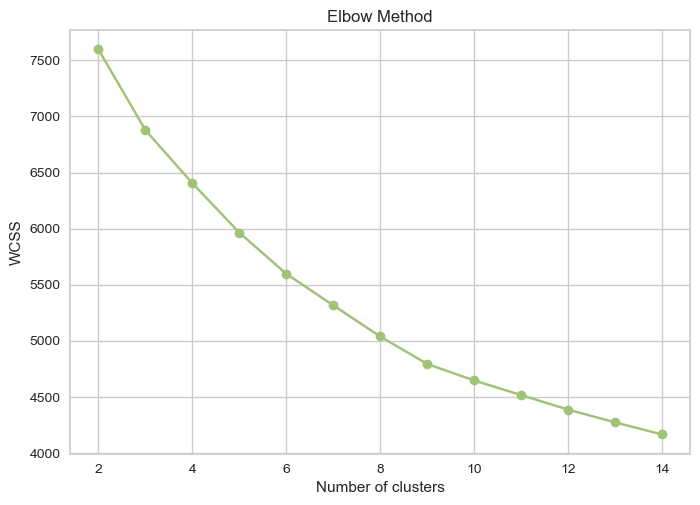

In [198]:
wcss = []  # Within-Cluster Sum of Squares 

k_grid = range(2, 15)
for i in k_grid:
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(k_grid, wcss, 'go-')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

### Yellow brick lib

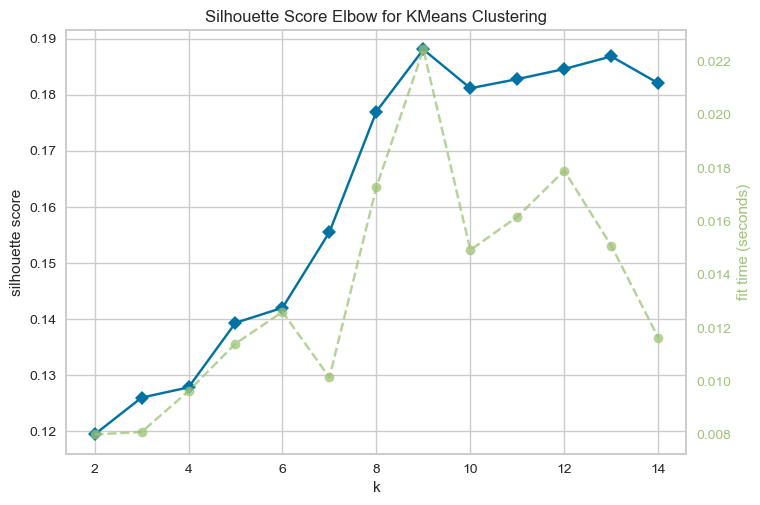

In [201]:
# Instantiate the clustering model and visualizer

# - **distortion**: mean sum of squared distances to centers
# - **silhouette**: mean ratio of intra-cluster and nearest-cluster distance
# - **calinski_harabasz**: ratio of within to between cluster dispersion

        
visualizer = KElbowVisualizer(KMeans(),
                              metric='silhouette',  # possible values: calinski_harabasz, distortion, silhouette
                              distance_metric="euclidean", # options allowed by sklearn's metrics.pairwise.pairwise_distances
                              k=k_grid,
                              timings=True,
                              locate_elbow=False, # True or False
                             )

visualizer.fit(X_scaled)        # Fit the data to the visualizer
visualizer.show();       # Finalize and render the figure

## Visualize the results on PCA-reduced data


### Profiling: cluster persona

In [205]:
reduced_data = PCA(n_components=2).fit_transform(X) 
kmeans = KMeans(init="k-means++", n_clusters=n_digits, n_init=4) 
kmeans.fit(reduced_data) 

kmean_labels = kmeans.labels_ 

In [208]:
data["cluster"] = kmean_labels
data.head()

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23,X24,X25,X26,X27,X28,X29,X30,X31,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41,X42,X43,X44,X45,X46,X47,X48,X49,X50,X51,X52,X53,X54,X55,X56,X57,X58,X59,X60,X61,X62,X63,label,cluster
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,13.0,15.0,10.0,15.0,5.0,0.0,0.0,3.0,15.0,2.0,0.0,11.0,8.0,0.0,0.0,4.0,12.0,0.0,0.0,8.0,8.0,0.0,0.0,5.0,8.0,0.0,0.0,9.0,8.0,0.0,0.0,4.0,11.0,0.0,1.0,12.0,7.0,0.0,0.0,2.0,14.0,5.0,10.0,12.0,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0,0,8
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,9.0,0.0,0.0,0.0,0.0,3.0,15.0,16.0,6.0,0.0,0.0,0.0,7.0,15.0,16.0,16.0,2.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,3.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,1.0,16.0,16.0,6.0,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0,1,5
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,3.0,16.0,15.0,14.0,0.0,0.0,0.0,0.0,8.0,13.0,8.0,16.0,0.0,0.0,0.0,0.0,1.0,6.0,15.0,11.0,0.0,0.0,0.0,1.0,8.0,13.0,15.0,1.0,0.0,0.0,0.0,9.0,16.0,16.0,5.0,0.0,0.0,0.0,0.0,3.0,13.0,16.0,16.0,11.0,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0,2,9
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,13.0,6.0,15.0,4.0,0.0,0.0,0.0,2.0,1.0,13.0,13.0,0.0,0.0,0.0,0.0,0.0,2.0,15.0,11.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,12.0,12.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,10.0,8.0,0.0,0.0,0.0,8.0,4.0,5.0,14.0,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0,3,7
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,13.0,6.0,2.0,2.0,0.0,0.0,0.0,7.0,15.0,0.0,9.0,8.0,0.0,0.0,5.0,16.0,10.0,0.0,16.0,6.0,0.0,0.0,4.0,15.0,16.0,13.0,16.0,1.0,0.0,0.0,0.0,0.0,3.0,15.0,10.0,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0,4,3


In [209]:
# Mapping cluster => label
contingency_table = pd.crosstab(data["cluster"], data["label"])
contingency_table

label,0,1,2,3,4,5,6,7,8,9
cluster,,,,,,,,,,
0,0,0,113,49,0,4,0,0,3,9
1,1,28,36,10,0,44,0,1,72,16
2,4,7,4,21,0,49,0,0,10,78
3,1,2,0,0,151,2,27,0,1,0
4,15,0,0,0,16,5,145,0,0,1
5,0,86,0,0,4,0,0,20,4,0
6,0,9,13,13,3,27,0,117,26,9
7,0,0,0,90,0,0,0,0,0,57
8,157,0,0,0,0,5,7,0,0,0


In [210]:
major_digit = contingency_table.idxmax(axis=1)
print(major_digit)

cluster
0    2
1    8
2    9
3    4
4    6
5    1
6    7
7    3
8    0
9    8
dtype: int32


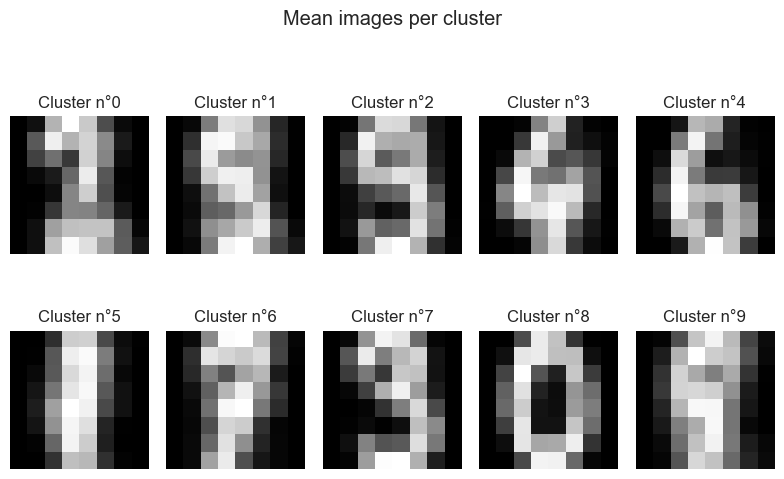

In [211]:
for cluster_id in range(n_digits):
    cluster_indices = np.where(kmean_labels == cluster_id)
    cluster_images = X[cluster_indices]
    mean_image = cluster_images.mean(axis=0).reshape(8, 8)
    
    plt.subplot(2, 5, cluster_id + 1)
    plt.imshow(mean_image, cmap='gray')
    plt.title(f"Cluster n°{cluster_id}")
    plt.axis('off')
    
plt.suptitle("Mean images per cluster")
plt.tight_layout()
plt.show()

### Visualization

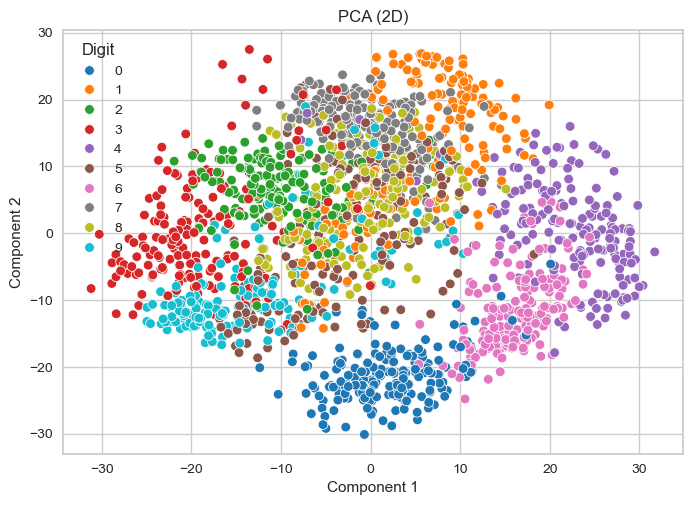

In [214]:
sns.scatterplot(x=reduced_data[:, 0], y=reduced_data[:, 1], hue=data.label, palette='tab10', legend='full')
plt.title("PCA (2D)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(title="Digit")
plt.show()


In [218]:


# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 0.02  # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(1)
plt.clf()
plt.imshow(
    Z,
    interpolation="nearest",
    extent=(xx.min(), xx.max(), yy.min(), yy.max()),
    cmap=plt.cm.Paired,
    aspect="auto",
    origin="lower",
)

plt.plot(reduced_data[:, 0], reduced_data[:, 1], "k.", markersize=2)
# Plot the centroids as a white X
centroids = kmeans.cluster_centers_
plt.scatter(
    centroids[:, 0],
    centroids[:, 1],
    marker="x",
    s=169,
    linewidths=3,
    color="w",
    zorder=10,
)
plt.title(
    "K-means clustering on the digits dataset (PCA-reduced data)\n"
    "Centroids are marked with white cross"
)
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xticks(())
plt.yticks(());

## Intercluster Distance Maps

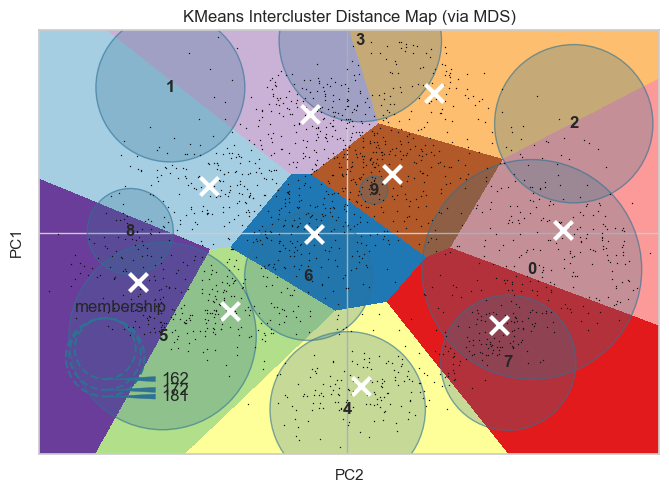

<Axes: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [222]:
# Instantiate the clustering model and visualizer
model = KMeans(10)
visualizer = InterclusterDistance(model)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

## Visualisation with TSNE

In [226]:
from sklearn.manifold import TSNE 

In [227]:
# Initialize

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_scaled) 


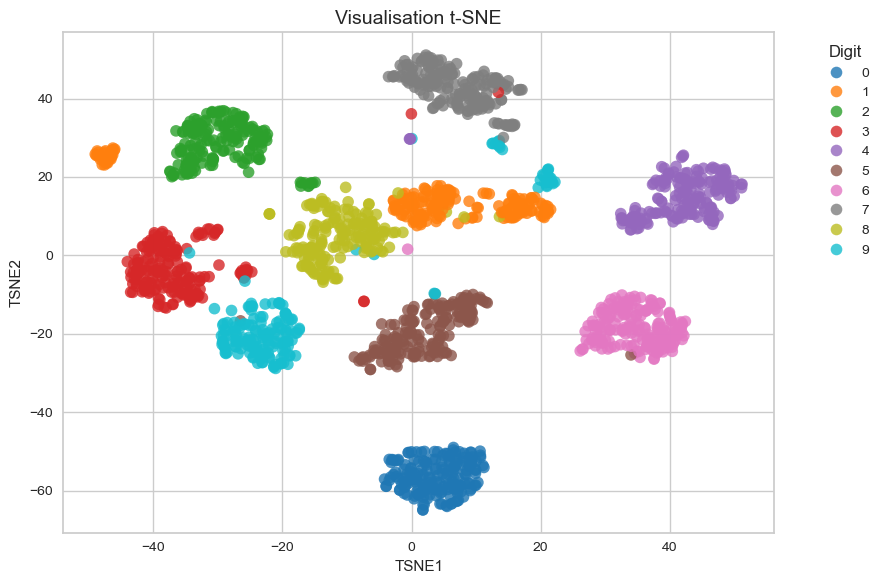

NameError: name 'kht' is not defined

In [230]:
df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['label'] = labels # Conversion en string pour une discrétisation catégorielle

# Plot
plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='label',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE', fontsize=14)
plt.legend(title='Digit', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
kht-oody-hec

# TP

### Grille d’optimisation

## K-Means

In [233]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import silhouette_score
from itertools import product
import pandas as pd
import numpy as np

# Définir les options de standardisation
scalers = {
    "none": None,
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "robust": RobustScaler()
}

# Autres hyperparamètres
pca_options = [False, True]
init_methods = ['k-means++', 'random']
n_clusters_range = range(5, 16)  # De 5 à 15 clusters
n_init_values = [10, 20]

results = []

# Boucle sur toutes les combinaisons
for scaler_name, scaler in scalers.items():
    for use_pca in pca_options:
        for init_method, n_init, n_clusters in product(init_methods, n_init_values, n_clusters_range):
            
            # Préparation des données
            if scaler:
                X_scaled = scaler.fit_transform(X)
            else:
                X_scaled = X.copy()
            
            if use_pca:
                pca = PCA(n_components=0.95, random_state=42)
                X_processed = pca.fit_transform(X_scaled)
            else:
                X_processed = X_scaled

            # Appliquer k-means
            kmeans = KMeans(n_clusters=n_clusters, init=init_method, n_init=n_init, random_state=42)
            labels = kmeans.fit_predict(X_processed)

            # Score de silhouette
            score = silhouette_score(X_processed, labels)

            # Sauvegarde des résultats
            results.append({
                "scaler": scaler_name,
                "pca": use_pca,
                "init": init_method,
                "n_init": n_init,
                "n_clusters": n_clusters,
                "silhouette": score
            })

# Convertir les résultats en DataFrame
results_df = pd.DataFrame(results)
best_config = results_df.sort_values(by="silhouette", ascending=False).iloc[0]
print("Meilleure configuration trouvée :")
print(best_config)


Meilleure configuration trouvée :
scaler            none
pca               True
init            random
n_init              20
n_clusters           9
silhouette    0.202004
Name: 81, dtype: object


La meilleure configuration possible stipule l'utilisation d'une methode de reduction de dimension PCA. Le nombre de cluster optimal est de 9 avec un score de silhouette de 0.202 avec l'option d'initialisation aléatoire en nombre de 20.

In [235]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Refaire le clustering avec la meilleure configuration
best_scaler = scalers[best_config['scaler']]
if best_scaler:
    X_scaled = best_scaler.fit_transform(X)
else:
    X_scaled = X.copy()  # Pas .values, car X est déjà un ndarray

if best_config["pca"]:
    pca = PCA(n_components=0.95, random_state=42)
    X_final = pca.fit_transform(X_scaled)
else:
    X_final = X_scaled

# Refaire le clustering
kmeans_best = KMeans(
    n_clusters=int(best_config['n_clusters']),
    init=best_config['init'],
    n_init=int(best_config['n_init']),
    random_state=42
)
labels_best = kmeans_best.fit_predict(X_final)

# ---------------------------------------
# 🔍 Analyse des personas (par cluster)
# ---------------------------------------

# Si vous avez un DataFrame original (avec noms de colonnes), utilisez-le ici
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['cluster'] = labels_best
personas = df.groupby('cluster').mean()
print("Analyse des personas (centres des clusters) :")
# print(personas)


Analyse des personas (centres des clusters) :


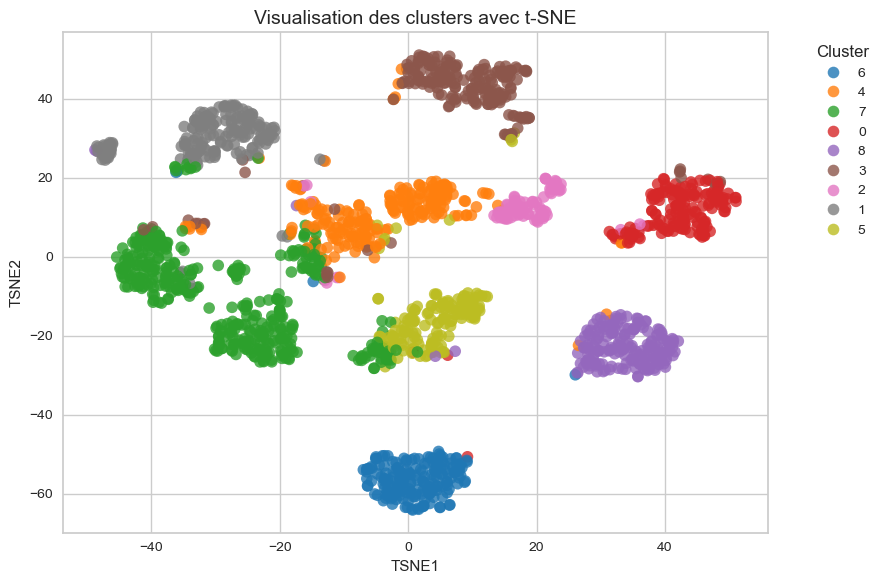

In [236]:

# ---------------------------------------
# 🎨 Visualisation avec t-SNE
# ---------------------------------------
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_final)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = labels_best.astype(str)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='cluster',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation des clusters avec t-SNE', fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Les clusters semblent homogène avec des points intrus pour quelques peu de cas. Le cluster 7 en vert semble former deux groupes ainsi que celui en orange c'est à dire le cluster 4.

Maintenant appliquons les meilleurs hyperparamètres pour voir s'il y a changement et plus d'homogenéïté

### Application des meilleurs paramètres de configuration 

In [240]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 1. Réduction de dimension avec PCA
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X)

# 2. Clustering avec le meilleur modèle
kmeans_best = KMeans(
    n_clusters=9,
    init='random',
    n_init=20,
    random_state=42
)
labels_best = kmeans_best.fit_predict(X_pca)

# 3. Analyse des personas
df = pd.DataFrame(X, columns=[f'feature_{i}' for i in range(X.shape[1])])
df['cluster'] = labels_best
personas = df.groupby('cluster').mean()
print("📊 Analyse des personas (centres des clusters) :")
# print(personas)


📊 Analyse des personas (centres des clusters) :


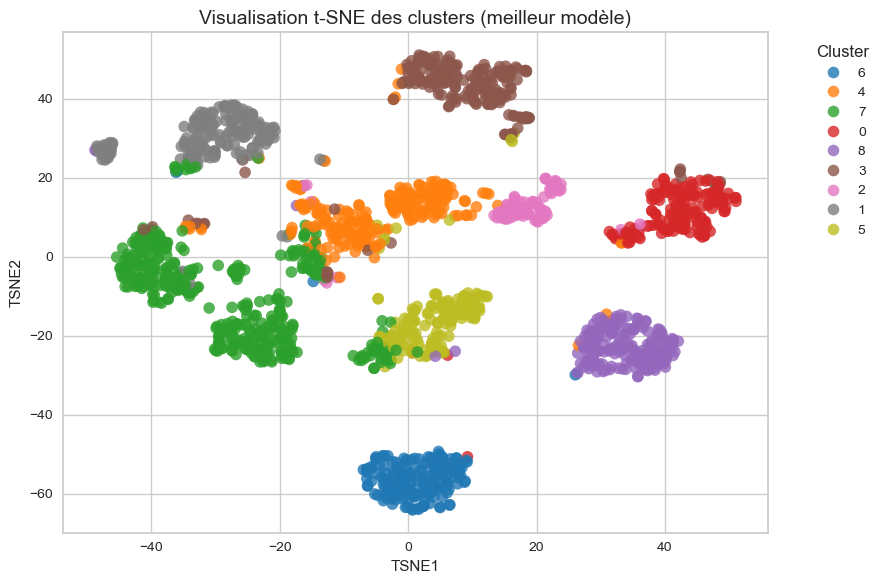

In [241]:

# 4. Visualisation t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30)
X_tsne = tsne.fit_transform(X_pca)

df_tsne = pd.DataFrame(X_tsne, columns=['TSNE1', 'TSNE2'])
df_tsne['cluster'] = labels_best.astype(str)

plt.figure(figsize=(9, 6))
sns.scatterplot(
    data=df_tsne,
    x='TSNE1',
    y='TSNE2',
    hue='cluster',
    palette='tab10',
    alpha=0.8,
    s=70,
    edgecolor='none'
)
plt.title('Visualisation t-SNE des clusters (meilleur modèle)', fontsize=14)
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


AU vue de la representation, les hyperparamètes ont eu un moindre impact. Peut être que le nombre de cluster est de trop ou que le modèle est peu adapté aux donnée. Nous allons élaborer dans la suite un modèle d'apprentissage profond qui combine reseaux de convolution CNN et le modèle de courte-longue memoire LSTM qui est adapté au traitement d'image

## Apprentissage Profond 

### 1. CNN + LSTM avant optimiastion

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, RepeatVector, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import tensorflow as tf
import os

# --- Section 1: Stabilisation du Code ---

# 1. Fixer les graines aléatoires pour la reproductibilité
def set_all_seeds(seed=42):
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    # Pour un comportement déterministe sur GPU (peut impacter les performances)
    # tf.config.experimental.set_synchronous_execution(True)

set_all_seeds(42)

# --- Section 2: Code Original avec Modifications pour la Stabilité ---

# Chargement des données DIGITS (8x8 images)
digits = load_digits()
X = digits.images  # Shape: (1797, 8, 8)
y_true = digits.target  # Pour visualisation (non utilisé dans clustering)

# Normalisation
X = X / 16.0  # Les valeurs vont de 0 à 16
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X.reshape(X.shape[0], -1)).reshape(X.shape[0], 8, 8)

# Autoencodeur CNN + LSTM
input_layer = Input(shape=(8, 8))
# Encoder
x = Conv1D(32, 3, activation="relu", padding="same")(input_layer)
x = LSTM(32, return_sequences=False)(x)
encoded = Dense(16, activation="relu", name="latent_space")(x)
# Decoder
x = RepeatVector(8)(encoded)
x = LSTM(32, return_sequences=True)(x)
decoded = TimeDistributed(Dense(8, activation="sigmoid"))(x)
autoencoder = Model(inputs=input_layer, outputs=decoded)
autoencoder.compile(optimizer=Adam(1e-3), loss="mse")

# Entraînement
# Ajoutez un EarlyStopping pour arrêter l'entraînement si la validation ne s'améliore plus
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=0)
autoencoder.fit(X_scaled, X_scaled, epochs=50, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping_callback])

# Encodage des données dans l’espace latent
encoder = Model(inputs=input_layer, outputs=autoencoder.get_layer("latent_space").output)
X_latent = encoder.predict(X_scaled)

# Clustering
# `n_init` est un paramètre important pour la stabilité de K-Means.
# Il est recommandé d'utiliser une valeur plus élevée pour de meilleurs résultats.
kmeans = KMeans(n_clusters=10, random_state=42, n_init=10) # Ajout de n_init
labels = kmeans.fit_predict(X_latent)
print("Silhouette Score:", silhouette_score(X_latent, labels))


Ce premier resultat est un peu haut (score de silhouette de 0.23) que celui du K-Means (0.20). Le nombre de cluster est de 10. Ci-dessous la representation graphique

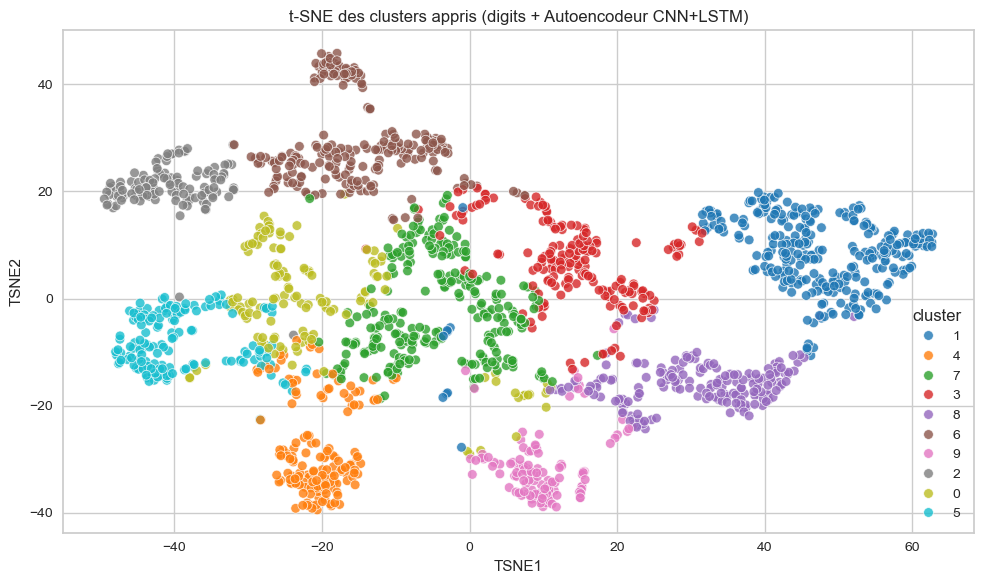

Personas (centroïdes latents) :
             0     1     2     3     4     5     6     7     8     9    10  \
cluster                                                                     
0        2.19  1.25  2.33  1.10  0.96  1.37  0.16  1.66  2.82  0.00  2.18   
1        3.10  2.82  4.09  2.29  1.14  2.00  0.01  3.62  2.32  0.00  2.66   
2        1.71  0.37  1.18  0.06  0.02  0.09  0.16  1.23  2.42  0.03  2.11   
3        2.51  1.45  2.75  3.29  2.24  2.47  0.00  2.83  3.24  0.00  1.63   
4        1.34  1.99  2.52  1.41  2.45  1.99  1.33  0.38  0.87  0.00  1.08   
5        2.09  1.86  3.19  0.44  0.43  1.19  0.32  0.75  1.54  0.01  2.59   
6        1.58  0.34  0.68  1.62  0.62  0.58  0.00  2.60  3.62  0.00  1.17   
7        2.07  1.28  2.15  1.87  2.26  1.87  0.10  2.01  2.52  0.00  1.31   
8        2.80  2.26  4.26  3.07  1.42  2.75  0.00  2.27  3.89  0.00  2.97   
9        1.53  1.19  3.42  2.54  1.27  2.42  0.00  0.42  3.64  0.00  1.80   

           11    12    13    14    15  
cl

In [311]:

# t-SNE pour visualiser les clusters
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_latent)

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["cluster"] = labels.astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="cluster", palette="tab10", alpha=0.8)
plt.title("t-SNE des clusters appris (digits + Autoencodeur CNN+LSTM)")
plt.tight_layout()
plt.show()

# Analyse des personas
df_latent = pd.DataFrame(X_latent)
df_latent["cluster"] = labels
personas = df_latent.groupby("cluster").mean()
print("Personas (centroïdes latents) :\n", personas.round(2))

Bien que le score de silhouette soit haut, des clusters sont dispersés.

Nous allons optimiser ce modèle pour voir si on peut obtenir bien plus. L'idée sera de minimiser la variance interne dans les clusters et que deux (2) clusters different aient des comportement different.

### 2. Emploie des meilleurs hyperparamètres : CNN + LSTM

### --- 2.1 Optimisation avec Hyperparamètres ---

In [319]:

# Définir les scalers
scalers = {
    "none": None,
    "standard": StandardScaler(),
    "minmax": MinMaxScaler(),
    "robust": RobustScaler()
}

# Grille d’hyperparamètres
latent_dims = [8, 16, 32]
cluster_range = range(8, 13)
init_methods = ['k-means++', 'random']
n_init_values = [10, 20]
results = []

# Boucle d’optimisation
for scaler_name, scaler in scalers.items():
    # Normalisation
    X_norm = X / 16.0
    if scaler:
        X_flat = scaler.fit_transform(X_norm.reshape(X.shape[0], -1))
        X_scaled_opt = X_flat.reshape(X.shape[0], 8, 8) # Renommé pour éviter conflit
    else:
        X_scaled_opt = X_norm.copy() # Renommé pour éviter conflit

    for latent_dim in latent_dims:
        # Création de l’autoencodeur
        input_layer = Input(shape=(8, 8))
        x = Conv1D(32, 3, activation="relu", padding="same")(input_layer)
        x = LSTM(32, return_sequences=False)(x)
        encoded = Dense(latent_dim, activation="relu", name="latent_space")(x)
        x = RepeatVector(8)(encoded)
        x = LSTM(32, return_sequences=True)(x)
        decoded = TimeDistributed(Dense(8, activation="sigmoid"))(x)
        autoencoder_opt = Model(input_layer, decoded) # Renommé pour éviter conflit
        autoencoder_opt.compile(optimizer=Adam(1e-3), loss="mse")
        # Utilisez le même EarlyStopping
        early_stop_opt = EarlyStopping(patience=5, restore_best_weights=True, verbose=0)
        
        autoencoder_opt.fit(
            X_scaled_opt, X_scaled_opt,
            epochs=50, batch_size=64,
            validation_split=0.1, verbose=0,
            callbacks=[early_stop_opt]
        )
        encoder_opt = Model(input_layer, autoencoder_opt.get_layer("latent_space").output) # Renommé
        X_latent_opt = encoder_opt.predict(X_scaled_opt) # Renommé

        for n_clusters in cluster_range:
            for init_method in init_methods:
                for n_init in n_init_values:
                    kmeans_opt = KMeans(n_clusters=n_clusters, init=init_method, n_init=n_init, random_state=42) # Renommé
                    labels_opt = kmeans_opt.fit_predict(X_latent_opt) # Renommé
                    score = silhouette_score(X_latent_opt, labels_opt)
                    results.append({
                        "scaler": scaler_name,
                        "latent_dim": latent_dim,
                        "n_clusters": n_clusters,
                        "init": init_method,
                        "n_init": n_init,
                        "silhouette": score
                    })

# Résultats
df_results = pd.DataFrame(results)
best_config = df_results.sort_values(by="silhouette", ascending=False).iloc[0]
print("✅ Meilleure configuration trouvée :\n", best_config)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
✅ Meilleure configuration trouvée :
 scaler            none
latent_dim          32
n_clusters           8
init            random
n_init              10
silhouette    0.502032
Name: 42, dtype: object


On voit que avec CNN+LSTM on a un meilleur aperçu de la situation. Après optimisation le nombre de cluster optimal est de 8 en tout. Le score de Silhouette est 0.50 superieur à 0.33 avant optimisation et supérieur à celui du K-means.

En comparant ce modèle à celui du K-Means, le modèle de convolution associé à celui de LSTM est le meilleur choix en terme de regroupement des clusters avec seulement 8 clusters

### --- 2.2 Reconstruction finale avec le meilleur modèle ---

In [322]:

# Prétraitement
best_scaler = scalers[best_config["scaler"]]
X_norm = X / 16.0
if best_scaler:
    X_flat = best_scaler.fit_transform(X_norm.reshape(X.shape[0], -1))
    X_scaled_final = X_flat.reshape(X.shape[0], 8, 8) # Renommé
else:
    X_scaled_final = X_norm.copy() # Renommé

# Autoencodeur
latent_dim = best_config["latent_dim"]
input_layer = Input(shape=(8, 8))
x = Conv1D(32, 3, activation="relu", padding="same")(input_layer)
x = LSTM(32, return_sequences=False)(x)
encoded = Dense(latent_dim, activation="relu", name="latent_space")(x)
x = RepeatVector(8)(encoded)
x = LSTM(32, return_sequences=True)(x)
decoded = TimeDistributed(Dense(8, activation="sigmoid"))(x)
autoencoder_final = Model(input_layer, decoded) # Renommé
autoencoder_final.compile(optimizer=Adam(1e-3), loss="mse")

57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


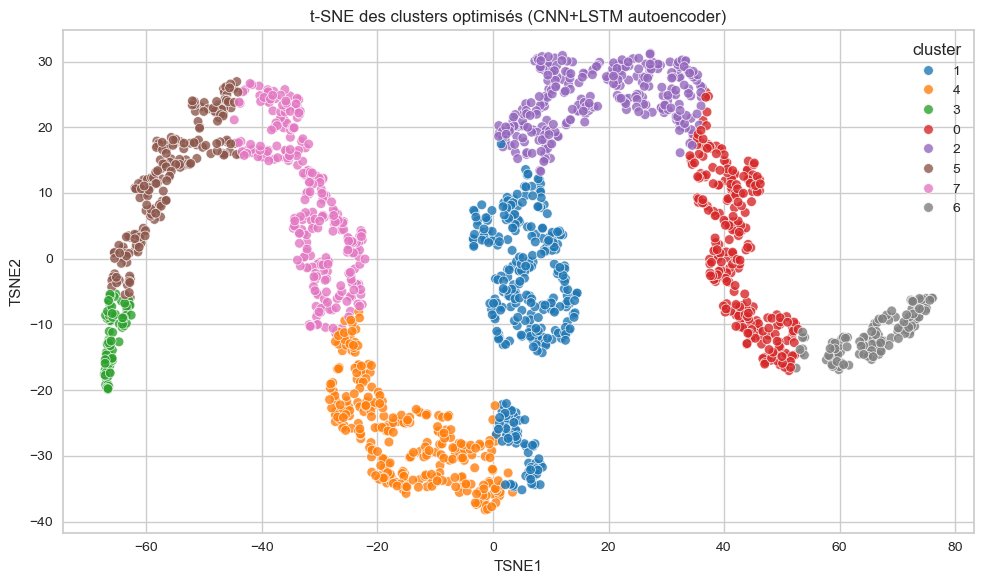

In [323]:
# Entraînement avec EarlyStopping
early_stop_final = EarlyStopping(patience=10, restore_best_weights=True, verbose=0)
autoencoder_final.fit(X_scaled_final, X_scaled_final, epochs=50, batch_size=64, validation_split=0.1, verbose=0, callbacks=[early_stop_final])

encoder_final = Model(input_layer, autoencoder_final.get_layer("latent_space").output) # Renommé
X_latent_final = encoder_final.predict(X_scaled_final) # Renommé

# Clustering
kmeans_best = KMeans(
    n_clusters=int(best_config["n_clusters"]),
    init=best_config["init"],
    n_init=int(best_config["n_init"]),
    random_state=42
)
labels_best = kmeans_best.fit_predict(X_latent_final) # Renommé

# t-SNE
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_latent_final) # Utilise X_latent_final

df_tsne = pd.DataFrame(X_tsne, columns=["TSNE1", "TSNE2"])
df_tsne["cluster"] = labels_best.astype(str)

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_tsne, x="TSNE1", y="TSNE2", hue="cluster", palette="tab10", alpha=0.8)
plt.title("t-SNE des clusters optimisés (CNN+LSTM autoencoder)")
plt.tight_layout()
plt.show()

Le regroupement des clusters affirment la présence de la précision. La reduction du nombre de cluster a apporté ses fruits. 
Même si on a pour certains clusters la variance intra un peu haut, le regroupement des données dans leur ensemble semblent suivre une loi.

In [324]:

# Analyse des personas
df_latent = pd.DataFrame(X_latent_final) # Utilise X_latent_final
df_latent["cluster"] = labels_best
personas = df_latent.groupby("cluster").mean()
print("\n📊 Personas (centroïdes latents) :\n", personas.round(2)) 


📊 Personas (centroïdes latents) :
            0     1     2     3    4     5     6    7    8    9    10    11  \
cluster                                                                      
0        0.0  2.69  2.95  3.96  0.0  9.19  4.51  0.0  0.0  0.0  3.56  2.36   
1        0.0  2.68  2.94  3.95  0.0  9.18  4.50  0.0  0.0  0.0  3.55  2.35   
2        0.0  2.69  2.94  3.95  0.0  9.19  4.50  0.0  0.0  0.0  3.55  2.35   
3        0.0  2.67  2.93  3.93  0.0  9.14  4.48  0.0  0.0  0.0  3.53  2.34   
4        0.0  2.68  2.94  3.95  0.0  9.17  4.49  0.0  0.0  0.0  3.55  2.35   
5        0.0  2.68  2.93  3.94  0.0  9.15  4.49  0.0  0.0  0.0  3.54  2.34   
6        0.0  2.69  2.95  3.96  0.0  9.20  4.51  0.0  0.0  0.0  3.56  2.36   
7        0.0  2.68  2.94  3.94  0.0  9.16  4.49  0.0  0.0  0.0  3.54  2.35   

          12   13   14    15    16   17   18    19   20   21   22    23    24  \
cluster                                                                         
0        0.0  0.0  0.

Les modèles d'apprentissage profond sont beaucoup plus adaptés au traitement d'image. La classification est beaucoup plus fine que celle de K-Means. D'ou l'intérêt pour ces types de modèles